<a href="https://colab.research.google.com/github/nagayoshi3/deep_learning_practice/blob/master/2_2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 転移学習

## モデルの構築

In [0]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers


model = models.Sequential()

# VGG16を追加
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model.add(conv_base)

# 出力層近くに全結合層を追加
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

conv_base.trainable = False

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## データの取得

Kaggleで利用された猫と犬の画像を取得します。

猫画像の例

![猫画像の例](https://storage.googleapis.com/kagglesdsdata/datasets/22535/28903/dataset/test_set/cats/cat.4003.jpg?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1573042509&Signature=LzyLZJL9T73mkZ8oshxrNZMUDEuGGGtU%2FtsFu0DgjgNemmG5xap9N3W40ntuHv52K5XX%2FpH4flggWomr1DzqVwSMTOlc39l64f2EZln077%2Fn9u4L4nCg%2Fn%2Fdd8WJLLnxXOkX4%2B%2B69%2FXfhcnE6vgUqQcLbON57zmH73jaqnMGUUtdacSKheaMa6sD0%2FRGi0rH%2BK0SmJPcGdQ0i%2FxD35LJb8tgBYKchBHKDZkHq%2B9negEn4DkDc0sOOGarzJFZs122YUb4Pys67dqil5ZcX%2BoX00ilmMeuY%2F4j7zs3HLu%2FiFOyTwrt9wjqXc3jXjUgtPRxGQRiD6MwhwpsCUi22BMIQw%3D%3D)

犬画像の例

![犬画像の例](https://storage.googleapis.com/kagglesdsdata/datasets/22535/28903/dataset/test_set/dogs/dog.4002.jpg?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1573042586&Signature=mDUsgkho%2BbaQ5PZL5Po%2FWWumqrNIicYiMDvklxq%2BppRcD32DrMwF9TnYD6TJaMnYvLF1EvmEGV9HXHisl3Gqv%2BgpjG6Jiu0GhzwM4VSRkCUbFwLpEE9tmSU0K9a0ZzrdTXuDX4sqxQCJnfjsHbqbchLkz4N6Z0e0zDypz4pPdJfrZ0WefvuX7uzqRkJ%2FxLcZyMTeritQ6v3E5b%2FK%2BMdJLfehNa%2FnjH9rHvFc%2BzBJrx43sURm%2BjsTAAZh65T5xIxixLma81%2FCx3xsjZ%2BMCAHKsKdkK3Hh%2BpanXJEqaFvXnEq124tnwYhHRa%2FLusY5WTaJuOXiJJziVMv9pxxilpVx1Q%3D%3D)

In [0]:
!wget https://www.dropbox.com/s/sk2uexuzkvq1ktc/dogs-vs-cats.zip?dl=0
!unzip dogs-vs-cats.zip?dl=0


import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'dogs-vs-cats'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


--2019-11-03 12:28:50--  https://www.dropbox.com/s/sk2uexuzkvq1ktc/dogs-vs-cats.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sk2uexuzkvq1ktc/dogs-vs-cats.zip [following]
--2019-11-03 12:28:50--  https://www.dropbox.com/s/raw/sk2uexuzkvq1ktc/dogs-vs-cats.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc083d87142894c90be2271d6d1.dl.dropboxusercontent.com/cd/0/inline/AroMl-TuJMMMA0YAaENT0Yv9n9XhSUUg1_TSn8Vn9GrcFRh6Va99n0ETPTADZ6zvSO25nQlJ5zL4MPmnxHpVQnmi9_WRGYKFAQxTI4lxkbmIyw/file# [following]
--2019-11-03 12:28:51--  https://ucc083d87142894c90be2271d6d1.dl.dropboxusercontent.com/cd/0/inline/AroMl-TuJMMMA0YAaENT0Yv9n9XhSUUg1_TSn8Vn9GrcFRh6Va99n0ETPTADZ6zvSO25nQlJ5zL4MPmnxHpVQnmi9_WRGYKFAQxTI4lxkbmIyw/file

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## モデルの学習

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/10
100/100 [==============================] - 27s 268ms/step - loss: 0.5868 - acc: 0.7035 - val_loss: 0.4341 - val_acc: 0.8310
Epoch 2/10
100/100 [==============================] - 25s 249ms/step - loss: 0.4750 - acc: 0.7830 - val_loss: 0.3571 - val_acc: 0.8640
Epoch 3/10
100/100 [==============================] - 25s 251ms/step - loss: 0.4423 - acc: 0.8045 - val_loss: 0.3215 - val_acc: 0.8720
Epoch 4/10
100/100 [==============================] - 25s 245ms/step - loss: 0.3974 - acc: 0.8300 - val_loss: 0.3022 - val_acc: 0.8810
Epoch 5/10
100/100 [==============================] - 25s 247ms/step - loss: 0.3784 - acc: 0.8345 - val_loss: 0.2848 - val_acc: 0.8910
Epoch 6/10
100/100 [==============================] - 24s 238ms/step - loss: 0.3566 - acc: 0.8555 - val_loss: 0.2732 - val_acc: 0.8960
Epoch 7/10
100/100 [==============================] - 24s 244ms/step - loss: 0.3645 - acc: 0.8365 - val_loss: 0.2679 - val_acc: 0.8920
Epoch 8/10
100/100 [==============================] - 2

### 評価


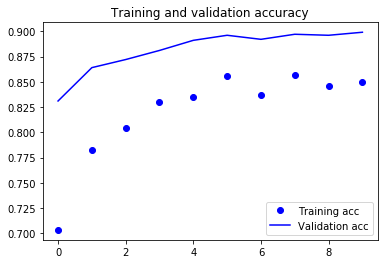

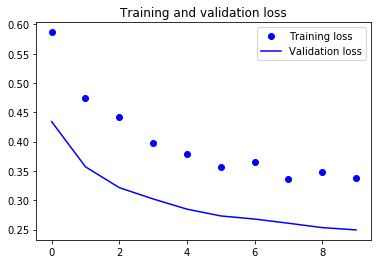

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()